<a href="https://colab.research.google.com/github/makkimaki/BERT_NLP_Udemy/blob/main/01_pytorch_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorchの基礎
PyTorchの基礎を学ぶために、ニューラルネットワークを訓練して手書き文字の認識を行います。 


## データの読み込み
`torchvision.datasets`を使って手書き文字のデータを読み込み、**DataLoader**を設定します。  
DataLoaderを使うと、データの読み込みやミニバッチ法の実装などが大幅に楽になります。   
`torchvision.datasets`にはMNISTの他にも様々なデータセットが用意されています。  
https://pytorch.org/docs/stable/torchvision/datasets.html


In [1]:
import torch
from torchvision.datasets import MNIST  # 手書き文字画像のデータ
from torchvision import transforms
from torch.utils.data import DataLoader

# 訓練データを取得
mnist_train = MNIST("./data", 
                    train=True, download=True,
                    transform=transforms.ToTensor())
# テストデータの取得
mnist_test = MNIST("./data",
                   train=False, download=True,
                   transform=transforms.ToTensor())
print("訓練データの数:", len(mnist_train), "テストデータの数:", len(mnist_test))

# DataLoaderの設定
img_size = 28
batch_size = 256
train_loader = DataLoader(mnist_train, 
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(mnist_test,
                         batch_size=batch_size,
                         shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
訓練データの数: 60000 テストデータの数: 10000






/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


手書き文字の画像サイズは、28×28になります。  



## モデルの構築
今回は、`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
`.cuda()`により、モデルの計算はGPU上で行われるようになります。  

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(img_size*img_size, 1024)  # 全結合層
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, img_size*img_size)  # バッチサイズ×入力の数
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  

1エポックの中で何度もミニバッチを使って訓練が行われるので、ミニバッチ法が実装されていることになります。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターにGPUが選択されていることを確認しましょう。


In [4]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(10):  # 10エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item() # テンソルから値を取り出す． .item()
        optimizer.zero_grad() #勾配の値をリセットする
        loss.backward() #勾配の計算のみを行う．
        optimizer.step() #パラメータの更新．　loss.backward()と分業している．
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        # 評価モードなのでパラメータの更新はいらない． loss.backwardは不要ということになる．
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 2.2127509238872123 Loss_Test: 2.080739068984985
Epoch: 1 Loss_Train: 1.8038079616871285 Loss_Test: 1.4086012452840806
Epoch: 2 Loss_Train: 1.0962938265597566 Loss_Test: 0.82225301861763
Epoch: 3 Loss_Train: 0.7196950633475121 Loss_Test: 0.601299325376749
Epoch: 4 Loss_Train: 0.5676601223489072 Loss_Test: 0.5001590937376023
Epoch: 5 Loss_Train: 0.48905655247099855 Loss_Test: 0.44081399105489255
Epoch: 6 Loss_Train: 0.44133457021510347 Loss_Test: 0.4020313426852226
Epoch: 7 Loss_Train: 0.408617177288583 Loss_Test: 0.37714283913373947
Epoch: 8 Loss_Train: 0.38559091179928884 Loss_Test: 0.35757642388343813
Epoch: 9 Loss_Train: 0.3678098054642373 Loss_Test: 0.34160803649574517


## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

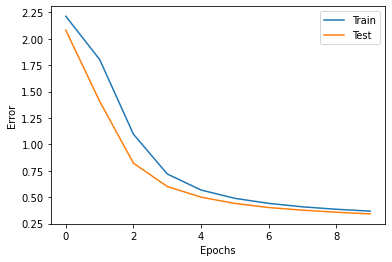

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [6]:
correct = 0
total = 0
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    x = x.view(-1, img_size*img_size)
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 90.27%
